In [1]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_adeno/meta/gdc_sample_sheet.2020-01-27.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['Project ID'].value_counts()

TCGA-LUSC    301
TCGA-LUAD    287
CPTAC-3      209
Name: Project ID, dtype: int64

Samples with RNAseq adjacent normal tissue

In [3]:
samples['Sample Type'].value_counts()

Primary Tumor                               558
Solid Tissue Normal                         206
Primary Tumor, Primary Tumor                 29
Solid Tissue Normal, Solid Tissue Normal      4
Name: Sample Type, dtype: int64

In [4]:
samples.loc[samples['Sample Type']=='Primary Tumor, Primary Tumor', 'Sample Type'] = 'Primary Tumor'
samples.loc[samples['Sample Type']=='Solid Tissue Normal, Solid Tissue Normal', 'Sample Type'] = 'Solid Tissue Normal'

In [5]:
samples['Sample Type'].value_counts()

Primary Tumor          587
Solid Tissue Normal    210
Name: Sample Type, dtype: int64

In [6]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [7]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()

176

210

In [8]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM')]
cases = pd.merge(case_tumor['Case ID'], case_norm['Case ID'])['Case ID']
cases.shape

(187,)

In [9]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [10]:
case_tumor.shape
case_norm.shape
cases.shape

(187, 9)

(176, 9)

(363, 9)

## Dataset Prep

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          140
Solid Tissue Normal    132
Name: Sample Type, dtype: int64

Primary Tumor          47
Solid Tissue Normal    44
Name: Sample Type, dtype: int64

In [12]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [13]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_adeno/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, norm=False)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, norm=False)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [14]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [15]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/272 (0%)]	Loss: 0.186468
Train: [240/272 (88%)]	Loss: 0.573355
Epoch: 1/20. Train set: Average loss: 0.5241
Epoch: 1/20. Validation set: Average loss: 2528.1217
Train: [0/272 (0%)]	Loss: 0.225592
Train: [240/272 (88%)]	Loss: 0.144387
Epoch: 2/20. Train set: Average loss: 0.1403
Epoch: 2/20. Validation set: Average loss: 236.3373
Train: [0/272 (0%)]	Loss: 0.048625
Train: [240/272 (88%)]	Loss: 0.056677
Epoch: 3/20. Train set: Average loss: 0.0552
Epoch: 3/20. Validation set: Average loss: 214.6242
Train: [0/272 (0%)]	Loss: 0.051783
Train: [240/272 (88%)]	Loss: 0.021570
Epoch: 4/20. Train set: Average loss: 0.0218
Epoch: 4/20. Validation set: Average loss: 71.8862
Train: [0/272 (0%)]	Loss: 0.008680
Train: [240/272 (88%)]	Loss: 0.010830
Epoch: 5/20. Train set: Average loss: 0.0102
Epoch: 5/20. Validation set: Average loss: 58.0367
Train: [0/272 (0%)]	Loss: 0.010867
Train: [240/272 (88%)]	Loss: 0.022442
Epoch: 6/20. Train set: Average loss: 0.0212
Epoch: 6/20. Validation set: Aver

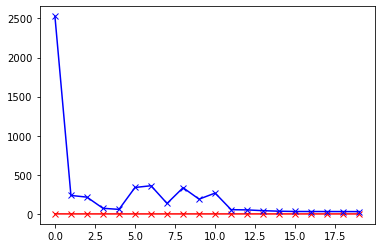

In [16]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

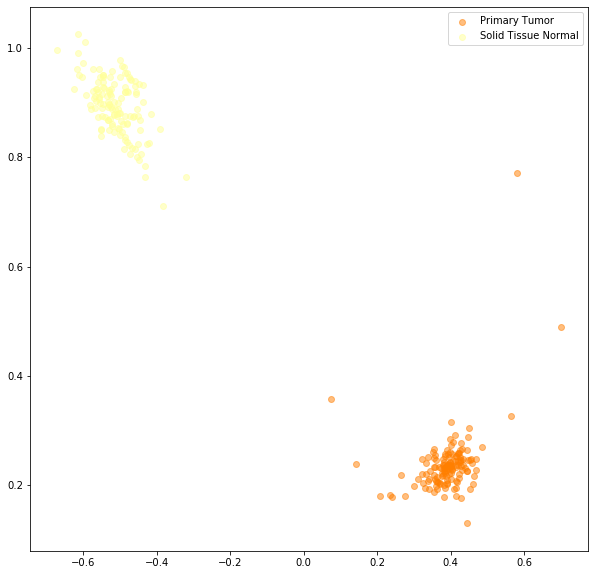

In [17]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

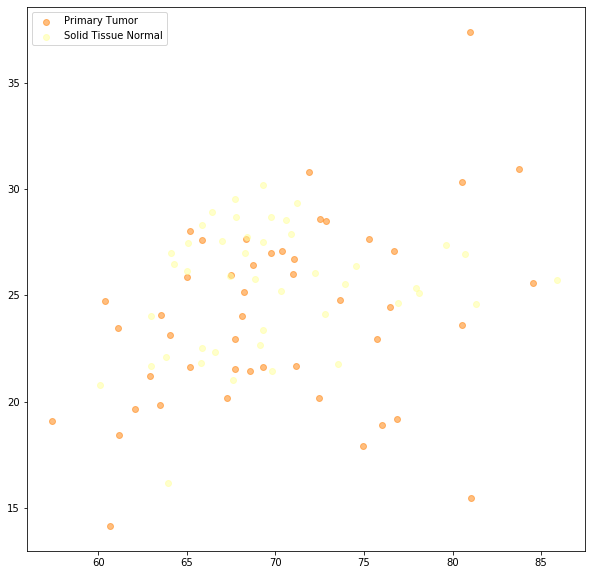

In [18]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)

## Integrated Gradients
Test completeness axiom through comparison of different baselines

"Integrated gradients satisfy an
axiom called completeness that the attributions add up to
the difference between the output of F at the input x and
the baseline x'."

In [ ]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

In [ ]:
tmp_model = copy.deepcopy(model)

In [ ]:
def attribution_pairs(SiameseTCGA, exp, ctrl):
    # subset different samples
    negative_pairs = np.array(SiameseTCGA.test_pairs)
    negative_pairs = negative_pairs[negative_pairs[:,2] == 0]
    # map labels to integers
    ctrl = siamese_test_dataset.labels_dict[ctrl]
    exp = siamese_test_dataset.labels_dict[exp]
    # ordered indices of samples
    ctrl_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[ctrl])]
    exp_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[exp])]
    # data
    ctrl_data = Variable(SiameseTCGA.test_data[ctrl_data], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[exp_data], requires_grad=True)
    return ctrl_data, exp_data

### IG with Control vector

In [ ]:

from captum.attr import LayerActivationctrl_data, exp_data = attribution_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [ ]:
ig = IntegratedGradients(tmp_model.get_embedding)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=0, n_steps=50, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

In [ ]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

### Test completeness axiom
- Euclidean Distance between samples
- feature attribution sum
- difference between

In [ ]:
pdist = torch.nn.PairwiseDistance(p=2)
outdist = pdist(exp_data, ctrl_data)

diff = np.round(outdist.detach().numpy() - attr.sum(axis=1), 3)
diff.mean(); np.median(diff); diff.var()

#### Inspect individual sample attributions

In [ ]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nlargest(10)

In [ ]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nsmallest(10)

#### Check embedding of zero-feature vector

In [ ]:
base_zero = torch.zeros(siamese_test_dataset.test_data.shape[1]).cuda()
base_emb = model.get_embedding(base_zero)
base_emb

#### Check loss of baseline vectors
- control data
- zero vector
- random values

In [ ]:
target = torch.tensor(0, dtype=float)
model.get_loss(ctrl_data.cuda(), exp_data.cuda(), target, ContrastiveLoss(margin))

In [ ]:
base_zero = torch.zeros(exp_data.shape).cuda()
model.get_loss(base_zero, exp_data.cuda(), target, ContrastiveLoss(margin))

In [ ]:
rand_base = torch.rand_like(exp_data).cuda()
model.get_loss(rand_base, exp_data.cuda(), target, ContrastiveLoss(margin))

### IG with zero-feature vector

In [ ]:
attr, delta = ig.attribute(exp_data.cuda(), target=0, n_steps=50, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

In [ ]:
attr.shape
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.hist(bins=100)
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

In [ ]:
pdist = torch.nn.PairwiseDistance(p=2)
outdist = pdist(exp_data, ctrl_data)

diff = np.round(outdist.detach().numpy() - attr.sum(axis=1), 3)
diff.mean(); np.median(diff); diff.var()

In [ ]:
for i in range(len(attr)):
    attr_samp = pd.Series(attr[i], index=train_dataset.data.columns)
    attr_samp.nlargest(10)